In [1]:
from google.colab import files
files.upload()  #upload file kaggle.json di folder

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ezzy19","key":"670b5f2b6ab9d2ec36cba0e69df39cb7"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permiss

kaggle.json


In [6]:
! kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 49.2MB/s]


In [7]:
#unzip file 
import os
!unzip /content/stock-time-series-20050101-to-20171231.zip

Archive:  /content/stock-time-series-20050101-to-20171231.zip
  inflating: AABA_2006-01-01_to_2018-01-01.csv  
  inflating: AAPL_2006-01-01_to_2018-01-01.csv  
  inflating: AMZN_2006-01-01_to_2018-01-01.csv  
  inflating: AXP_2006-01-01_to_2018-01-01.csv  
  inflating: BA_2006-01-01_to_2018-01-01.csv  
  inflating: CAT_2006-01-01_to_2018-01-01.csv  
  inflating: CSCO_2006-01-01_to_2018-01-01.csv  
  inflating: CVX_2006-01-01_to_2018-01-01.csv  
  inflating: DIS_2006-01-01_to_2018-01-01.csv  
  inflating: GE_2006-01-01_to_2018-01-01.csv  
  inflating: GOOGL_2006-01-01_to_2018-01-01.csv  
  inflating: GS_2006-01-01_to_2018-01-01.csv  
  inflating: HD_2006-01-01_to_2018-01-01.csv  
  inflating: IBM_2006-01-01_to_2018-01-01.csv  
  inflating: INTC_2006-01-01_to_2018-01-01.csv  
  inflating: JNJ_2006-01-01_to_2018-01-01.csv  
  inflating: JPM_2006-01-01_to_2018-01-01.csv  
  inflating: KO_2006-01-01_to_2018-01-01.csv  
  inflating: MCD_2006-01-01_to_2018-01-01.csv  
  inflating: MMM_2006-01

In [8]:
#librari yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [181]:
#ubah dataset ke dataframe dengan fungsi read_csv()
df = pd.read_csv ('/content/AMZN_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [182]:
#cek data yg hilang pakai fungsi isnull()
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [183]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object

In [184]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08


Text(0.5, 0, 'Datetime')

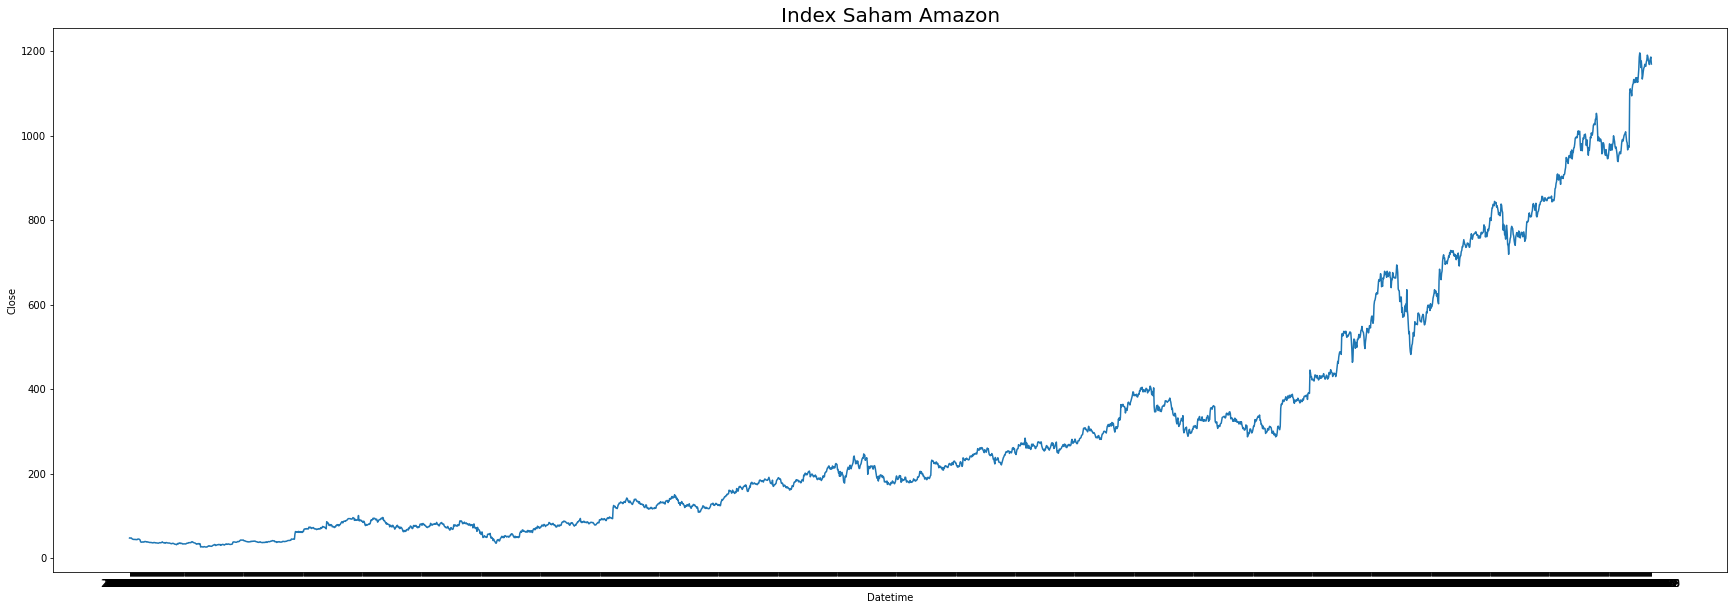

In [185]:
date = df['Date'].values
Close = df['Close'].values
plt.figure(figsize=(30,10))
plt.plot(date, Close)
plt.title('Index Saham Amazon', fontsize = 20)
plt.ylabel('Close')
plt.xlabel('Datetime')

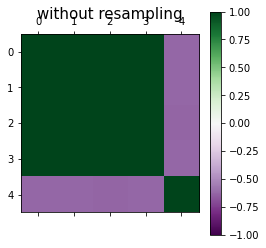

In [187]:
# Correlations among columns
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

In [188]:
#membagi data kedalam train dan test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =train_test_split(date, Close, train_size=0.8, test_size=0.2, shuffle=False)

panjangTrainData = len (x_train)
panjangTestData = len (y_test)

print('jumlah data train adalah {}'.format(panjangTrainData))
print('jumlah data test adalah {}'.format(panjangTestData))


jumlah data train adalah 2415
jumlah data test adalah 604


In [189]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [193]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
#definiskan model dengan LSTM
model = Sequential([
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
                    Dropout(0.3),
                    Dense(30, activation="relu"),
                    Dense(10, activation="relu"),
                    Dense(1)])

In [194]:
#menggunakan callback supaya jika tujuan telah tercapai ,proses epoch dihentikan
class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae') <=98):
      print('\nMae telah mencapai <=10%!')
      self.model.stop_training = True
callbacks = myCallbacks()

In [195]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=100,
                    callbacks =[callbacks])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 5s 216ms/step - loss: 178.8039 - mae: 179.3039
Epoch 2/100
24/24 [==============================] - 5s 216ms/step - loss: 178.4555 - mae: 178.9555
Epoch 3/100
24/24 [==============================] - 5s 212ms/step - loss: 178.0511 - mae: 178.5511
Epoch 4/100
24/24 [==============================] - 5s 214ms/step - loss: 177.5085 - mae: 178.0085
Epoch 5/100
24/24 [==============================] - 5s 215ms/step - loss: 176.7440 - mae: 177.2440
Epoch 6/